# Подбор важности фич для k-nearest neighbors (ну или других гиперпараметров) спуском похожим на градиентный.
Экспериментируя с простейшей задачкой машинного обучения я обнаружил, что интересно было бы подобрать в довольно широком диапазоне значения 18 гиперпараметров одновременно. В моём случае всё было на столько несложно, что задачку можно было бы взять и грубой компьютерной силой.

Обучаясь чему-то мне бывает очень интересно изобрести какой-нибудь велосипед. Иногда получается реально придумать что-то новое. Иногда обнаруживается, что все придумано до меня. Но даже если я всего лишь повторю путь пройденный за долго до меня, в награду я часто получаю понимание глубинных механизмов алгоритмов их возможностей и внутренних ограничений. К чему и вас приглашаю.

В Python и DS я, сказать мягко, новичок, и многие вещи, которые можно реализовать в одну команду по своей старой программистской привычке делаю кодом, за что Python наказывает замедлением даже не в разы, а на порядки. Поэтому весь свой код я выкладываю в репозиторий. Если знаете как реализовать сильно эффективнее - не стесняйтесь, правьте там, или пишите в комментариях. https://github.com/kraidiky/GDforHyperparameters

Тем, кто уже крутой датасатанист, и всё в этой жизни попробовал небезинтересна будет, я полагаю, визуализация процесса обучения, которая пименима не только к этой задачке.
## Постановка задачи
Есть такой хороший курс по DS от ODS.ai и там третья лекция <a href="https://habr.com/ru/company/ods/blog/322534/">Классификация, деревья решений и метод ближайших соседей</a>. Там на предельно простых и, вероятно, синтетических данных показывается как простейшее дерево решений даёт точность 94.5%, а такой же предельно простой метод k ближайших соседей без всякой предобработки даёт 89%

In [2]:
# Импорт и загрузка данных
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/telecom_churn.csv')
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Churn'] = df['Churn'].astype('int32')
states = df['State']
y = df['Churn']
df.drop(['State','Churn'], axis = 1, inplace=True)
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [3]:
%%time
# Сравнение дерева с knn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(random_state=17, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=10)

tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}
tree_grid = GridSearchCV(tree, tree_params, cv=10, n_jobs=-1, verbose=False)
tree_grid.fit(X_train, y_train)
tree_grid.best_params_, tree_grid.best_score_, accuracy_score(y_holdout, tree_grid.predict(X_holdout))

Wall time: 6.95 s


({'max_depth': 6, 'max_features': 16}, 0.944706386626661, 0.945)

In [4]:
%%time
# то же для knn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=10, n_jobs=-1, verbose=False)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_, accuracy_score(y_holdout, knn_grid.predict(X_holdout))

Wall time: 2.96 s


({'knn__n_neighbors': 9}, 0.8868409772824689, 0.891)

На этом месте мне стало обидно за knn явно поставленный в нечестные условия, ведь с метрикой длинны мы никак не поработали. Я не стал думать мозгом, взял feature_importances_ у дерева и отнормировал входные данные на него.

In [5]:
feature_importances = pd.DataFrame({'features': df.columns, 'importance':tree_grid.best_estimator_.feature_importances_})
print(feature_importances.sort_values(by=['importance'], inplace=False, ascending=False))

                  features  importance
5        Total day minutes    0.270386
17  Customer service calls    0.147185
8        Total eve minutes    0.135475
2       International plan    0.097249
16       Total intl charge    0.091671
15        Total intl calls    0.090008
4    Number vmail messages    0.050646
10        Total eve charge    0.038593
7         Total day charge    0.026422
3          Voice mail plan    0.017068
11     Total night minutes    0.014185
13      Total night charge    0.005742
12       Total night calls    0.005502
9          Total eve calls    0.003614
6          Total day calls    0.002246
14      Total intl minutes    0.002009
0           Account length    0.001998
1                Area code    0.000000


In [6]:
%%time
#Скармливаем данные отнормированные на важность фич
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_train_transformed = X_train_transformed * np.array(feature_importances['importance'])

X_holdout_transformed = scaler.transform(X_holdout)
X_holdout_transformed = X_holdout_transformed * np.array(feature_importances['importance'])

knn_grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 11, 2)}, cv=5, n_jobs=-1, verbose=False)
knn_grid.fit(X_train_transformed, y_train)
print (knn_grid.best_params_, knn_grid.best_score_, accuracy_score(y_holdout, knn_grid.predict(X_holdout_transformed)))

{'n_neighbors': 5} 0.909129875696528 0.913
Wall time: 1.04 s


Дерево всего чуть-чуть поделилось с knn своими знаниями и вот мы видим уже 91% Что уже не так далеко от 94.5% у ванильного дерева. И вот тут меня и посетила идея. А как, собственно, надо отнормировать входные данные чтобы knn показала наилучший результат?

Сначала прикинем в уме сколько вот это вот будет считаться "в лоб". 18 параметров, для каждого сделаем, допустим, 10 возможных ступеней множителей в логарифмической шкале. Получаем 10е18 вариантов. Один вариант со всем возможным нечётным количеством соседей меньше 10 и кроссвалидацией тоже 10 у меня считается примерно 1.5 секунды. Получается 42 млрд. лет. От идеи оставить считаться на ночь придётся, пожалуй, отказаться. :) И вот где-то тут я подумал "Эй! Так я ща сделаю велосипед, который полетит!"

## Околоградиентный поиск
Вообще-то у этой задачи, скорее всего, всего один доступный максимум. Ну тоесть не один конечно, целая область неплохих результатов, но они довольно сильно похожи друг на друга. Поэтому мы можем просто пройти по градиенту и найти наиболее подходящую точку. Первая мысль была вообще генетический алгоритм запилить, но здесь адаптивный рельеф представляется не сильно пересечённым, и это был бы уже немножечко перебор.

Попробую сделать это вручную для начала. Чтобы запихивать множетели в качестве гиперпараметров мне потребуется разобраться со скейлерами. В прошлом примере я, как и в уроке, применил StandartScaler, который учебную выборку отцентровал по среденму и сделал sigma = 1. Для того чтобы её красиво масштабировать внутри пайплайна гиперпараметром придётся сделать чуть-чуть хитрее. Я начал искать среди преобразователей лежищих в sklearn.preprocessing что-то подходящее к моему случаю, но ничего не нашёл. Поэтому я попытался отнаследоваться от StandartScaler навешав на него дополнительную пачку множителей.

In [8]:
# Класс для номализации а потом умножения на масштаб слегка совместимый с пайплайном sklearn
from sklearn.base import TransformerMixin
class StandardAndPoorScaler(StandardScaler, TransformerMixin):
    #normalization = None
    def __init__(self, copy=True, with_mean=True, with_std=True, normalization = None):
        #print("new StandardAndPoorScaler(normalization=", normalization.shape if normalization is not None else normalization, ") // ", type(self))
        self.normalization = normalization
        super().__init__(copy, with_mean, with_std)
    def fit(self, X, y=None):
        #print(type(self),".fit(",X.shape, ",", y.shape if y is not None else "<null>",")")
        super().fit(X, y)
        return self
    def partial_fit(self, X, y=None):
        #print(type(self),".partial_fit(",X.shape, ",", y.shape if y is not None else "<null>)")
        super().partial_fit(X, y)
        if self.normalization is None:
            self.normalization = np.ones((X.shape[1]))
        elif type(self.normalization) != np.ndarray:
            self.normalization = np.array(self.normalization)
        if X.shape[1] != self.normalization.shape[0]:
            raise "X.shape[1]="+X.shape[1]+" in equal self.scale.shape[0]="+self.normalization.shape[0]
    def transform(self, X, copy=None):
        #print(type(self),".transform(",X.shape,",",copy,").self.normalization", self.normalization)
        Xresult = super().transform(X, copy)
        Xresult *= self.normalization
        return Xresult
    def _reset(self):
        #print(type(self),"._reset()")
        super()._reset()
    
scaler = StandardAndPoorScaler(normalization = feature_importances['importance'])
scaler.fit(X = X_train, y = None)
print(scaler.normalization)

[0.00199812 0.         0.09724865 0.01706831 0.05064639 0.27038647
 0.00224566 0.02642208 0.13547473 0.00361444 0.03859313 0.01418539
 0.00550187 0.00574233 0.00200928 0.09000768 0.09167069 0.14718478]


In [7]:
%%time
#Попытка этот класс применить
knn_pipe = Pipeline([('scaler', StandardAndPoorScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 11, 4), 'scaler__normalization': [feature_importances['importance']]}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=False)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_, accuracy_score(y_holdout, knn_grid.predict(X_holdout))

Wall time: 682 ms


({'knn__n_neighbors': 5, 'scaler__normalization': 0     0.001998
  1     0.000000
  2     0.097249
  3     0.017068
  4     0.050646
  5     0.270386
  6     0.002246
  7     0.026422
  8     0.135475
  9     0.003614
  10    0.038593
  11    0.014185
  12    0.005502
  13    0.005742
  14    0.002009
  15    0.090008
  16    0.091671
  17    0.147185
  Name: importance, dtype: float64}, 0.909558508358337, 0.913)

Результат несколько отличается от моих ожиданий. Ну то есть в принципе всё работает. Вот только чтобы это понять, мне пришлось за три часа воспроизвести этот класс со всеми потрохами с нуля, и только тогда я понял, что print нихрена не печатает не потому что sklearn как-то неправильно сделан, а потому что GridSearchCV клоны создаёт в основном потоке, а настраивает и обучает их в других потоках. А всё что там печатаешь в других потоках исчезает в небытии. А вот если n_jobs=1 поставить, то все вызовы переопределённых функций показываются как милые. Очень дорогое вышло знание, теперь оно у вас тоже есть, и вы заплатили за него чтением нудной статьи.

Ладно, пошли дальше. У меня 18 параметров и пытаться играться всеми сразу - полное безумие. Попробую играться параметрами группами по три штучки. В качестве начального состояния возьму для начала то, что выдало мне дерево, а то вдруг там ни один параметр нельзя улучшить. Первый раз выбираю параметры, которые буду менять вручную. Это 3-ий, 4-ый и 5-ый, и сформирую набор данных, где каждый из этих параметров немного отличается в кажлом варианте.

In [8]:
feature_base = feature_importances['importance']
searchArea = np.array([feature_base - .05, feature_base, feature_base + .05])
searchArea[searchArea < 0] = 0
searchArea[searchArea > 1] = 1
print(searchArea[2,:] - searchArea[0,:])

[0.05199812 0.05       0.1        0.06706831 0.1        0.1
 0.05224566 0.07642208 0.1        0.05361444 0.08859313 0.06418539
 0.05550187 0.05574233 0.05200928 0.1        0.1        0.1       ]


In [9]:
import itertools

affected_props = [2,3,4]
parametrs_ranges = np.concatenate([
    np.linspace(searchArea[0,affected_props], searchArea[1,affected_props], 2, endpoint=False),
    np.linspace(searchArea[1,affected_props], searchArea[2,affected_props], 3, endpoint=True)]).transpose()

print(parametrs_ranges) # По пять вариантов значения каждого параметра. Всего 125 комбинаций
recombinations = itertools.product(parametrs_ranges[0],parametrs_ranges[1],parametrs_ranges[1])

variances = []
for item in recombinations: # Не знаю как это вот всё сделать в одну строчку, поэтому будут мои омерзительно медленные в Python циклы.
    varince = feature_base.copy()
    varince[affected_props] = item
    variances.append(varince)
print(variances[0])
print(len(variances))
# Методу knn важно только соотношение, поэтому можно не нормировать вообще или нормировать только при переходе от одной выборки к другой.

[[0.04724865 0.07224865 0.09724865 0.12224865 0.14724865]
 [0.         0.00853416 0.01706831 0.04206831 0.06706831]
 [0.00064639 0.02564639 0.05064639 0.07564639 0.10064639]]
0     0.001998
1     0.000000
2     0.047249
3     0.000000
4     0.000000
5     0.270386
6     0.002246
7     0.026422
8     0.135475
9     0.003614
10    0.038593
11    0.014185
12    0.005502
13    0.005742
14    0.002009
15    0.090008
16    0.091671
17    0.147185
Name: importance, dtype: float64
125


Ну вот, набор данных для первого эксперимента готов. Теперь попробую проэкспериментировать с данными, для начала полным перебором.

In [10]:
%%time
#scale = np.ones([18])
knn_pipe = Pipeline([('scaler', StandardAndPoorScaler()), ('knn', KNeighborsClassifier(n_neighbors = 7 , n_jobs=-1))])

knn_params = {'scaler__normalization': variances} # 'knn__n_neighbors': range(3, 9, 2), 
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=10, n_jobs=-1, verbose=False)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_, accuracy_score(y_holdout, knn_grid.predict(X_holdout))

Wall time: 36.6 s


({'scaler__normalization': 0     0.001998
  1     0.000000
  2     0.097249
  3     0.067068
  4     0.008534
  5     0.270386
  6     0.002246
  7     0.026422
  8     0.135475
  9     0.003614
  10    0.038593
  11    0.014185
  12    0.005502
  13    0.005742
  14    0.002009
  15    0.090008
  16    0.091671
  17    0.147185
  Name: importance, dtype: float64}, 0.9121303043291898, 0.915)

Ну и всё плохо, времени потрачена прорва, а результат очень неустойчив. Это и по проверке по X_holdout видно, результат пляшет как в колейдоскопе при незначительных изменениях входных данных. Попробую другой подход. Буду менять только один параметр одновременно но зато с многократно большей дискретизацией.

In [11]:
%%time
# Меняю одно 4-ое свойство
affected_property = 4
parametrs_range = np.concatenate([
    np.linspace(searchArea[0,affected_property], searchArea[1,affected_property], 29, endpoint=False),
    np.linspace(searchArea[1,affected_property], searchArea[2,affected_property], 30, endpoint=True)]).transpose()

print(searchArea[1,affected_property])
print(parametrs_range) # Cканируем по одному параметру, зато плотно.


variances = []
for item in parametrs_range: # Не знаю как это вот всё сделать в одну строчку, поэтому будут мои омерзительно медленные в Python циклы.
    varince = feature_base.copy()
    varince[affected_property] = item
    variances.append(varince)
print(variances[0])
print(len(variances))
# Методу knn важно только соотношение, поэтому можно не нормировать вообще или нормировать только при переходе от одной выборки к другой.

knn_pipe = Pipeline([('scaler', StandardAndPoorScaler()), ('knn', KNeighborsClassifier(n_neighbors = 7 , n_jobs=-1))])

knn_params = {'scaler__normalization': variances} # 'knn__n_neighbors': range(3, 9, 2), 
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=10, n_jobs=-1, verbose=False)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_, accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.05064639398606808
[0.00064639 0.00237053 0.00409467 0.00581881 0.00754295 0.00926708
 0.01099122 0.01271536 0.0144395  0.01616364 0.01788777 0.01961191
 0.02133605 0.02306019 0.02478433 0.02650846 0.0282326  0.02995674
 0.03168088 0.03340501 0.03512915 0.03685329 0.03857743 0.04030157
 0.0420257  0.04374984 0.04547398 0.04719812 0.04892226 0.05064639
 0.05237053 0.05409467 0.05581881 0.05754295 0.05926708 0.06099122
 0.06271536 0.0644395  0.06616364 0.06788777 0.06961191 0.07133605
 0.07306019 0.07478433 0.07650846 0.0782326  0.07995674 0.08168088
 0.08340501 0.08512915 0.08685329 0.08857743 0.09030157 0.0920257
 0.09374984 0.09547398 0.09719812 0.09892226 0.10064639]
0     0.001998
1     0.000000
2     0.097249
3     0.017068
4     0.000646
5     0.270386
6     0.002246
7     0.026422
8     0.135475
9     0.003614
10    0.038593
11    0.014185
12    0.005502
13    0.005742
14    0.002009
15    0.090008
16    0.091671
17    0.147185
Name: importance, dtype: float64
59
Wall time: 17.5

({'scaler__normalization': 0     0.001998
  1     0.000000
  2     0.097249
  3     0.017068
  4     0.079957
  5     0.270386
  6     0.002246
  7     0.026422
  8     0.135475
  9     0.003614
  10    0.038593
  11    0.014185
  12    0.005502
  13    0.005742
  14    0.002009
  15    0.090008
  16    0.091671
  17    0.147185
  Name: importance, dtype: float64}, 0.9099871410201458, 0.913)

Ну, и что мы имеем с гуся? Подвижки в одну-две десятые процента на кроссвалиадации, и скачка на пол процента на X_holdout если посмотреть при разных affected_property. Видимо существенно и дёшево улучшить ситуацию если начинать с того, что нам даёт дерево невозможно на таких данных. Но допустим, что начальной, заранее известной развесовки у нас нет, и попробуем осуществить то же самое в призвольной точки в цикле малюсенькими шажочками. Очень интересно к чему придём.

In [12]:
# Первоначальное наполнение 
searchArea = np.array([np.zeros((18,)), np.ones((18,)) /18, np.ones((18,))])
print(searchArea[:,0])

history_parametrs = [searchArea[1,:].copy()]
scaler = StandardAndPoorScaler(normalization=searchArea[1,:])
scaler.fit(X_train)
knn = KNeighborsClassifier(n_neighbors = 7 , n_jobs=-1)
knn.fit(scaler.transform(X_train), y_train)
history_holdout_score = [accuracy_score(y_holdout, knn.predict(scaler.transform(X_holdout)))]


[0.         0.05555556 1.        ]


In [13]:
%%time
def changePropertyNormalization(affected_property, points_count = 15):
    test_range = np.concatenate([
        np.linspace(searchArea[0,affected_property], searchArea[1,affected_property], points_count//2, endpoint=False),
        np.linspace(searchArea[1,affected_property], searchArea[2,affected_property], points_count//2 + 1, endpoint=True)]).transpose()
    variances = [searchArea[1,:].copy() for i in range(test_range.shape[0])]
    for row in range(len(variances)):
        variances[row][affected_property] = test_range[row]
    
    knn_pipe = Pipeline([('scaler', StandardAndPoorScaler()), ('knn', KNeighborsClassifier(n_neighbors = 7 , n_jobs=-1))])
    knn_params = {'scaler__normalization': variances} # 'knn__n_neighbors': range(3, 9, 2), 
    knn_grid = GridSearchCV(knn_pipe, knn_params, cv=10, n_jobs=-1, verbose=False)

    knn_grid.fit(X_train, y_train)
    holdout_score = accuracy_score(y_holdout, knn_grid.predict(X_holdout))
    best_param = knn_grid.best_params_['scaler__normalization'][affected_property]
    print(affected_property,
          'property:', searchArea[1, affected_property], "=>", best_param,
          'holdout:', history_holdout_score[-1], "=>", holdout_score, '(', knn_grid.best_score_, ')')
    # А вот теперь надо решить как изменить в связи с этим диапазон поиска.
    before = searchArea[:, affected_property]
    propertySearchArea = searchArea[:, affected_property].copy()
    if best_param == propertySearchArea[0]:
        print('|<<')
        searchArea[0, affected_property] = best_param/2 if best_param > 0.01 else 0
        searchArea[2, affected_property] = (best_param + searchArea[2, affected_property])/2
        searchArea[1, affected_property] = best_param
    elif best_param == propertySearchArea[2]:
        print('>>|')
        searchArea[2, affected_property] = (best_param + 1)/2 if best_param < 0.99 else 1
        searchArea[0, affected_property] = (best_param + searchArea[0, affected_property])/2
        searchArea[1, affected_property] = best_param
    elif best_param < (propertySearchArea[0] + propertySearchArea[1])/2:
        print('<<')
        searchArea[0, affected_property] = max(propertySearchArea[0]*1.1 - .1*propertySearchArea[1], 0)
        searchArea[2, affected_property] = (best_param + propertySearchArea[2])/2
        searchArea[1, affected_property] = best_param
    elif best_param > (propertySearchArea[1] + propertySearchArea[2])/2:
        print('>>')
        searchArea[0, affected_property] = (best_param + propertySearchArea[0])/2
        searchArea[2, affected_property] = min(propertySearchArea[2]*1.1 - .1*propertySearchArea[1], 1)
        searchArea[1, affected_property] = best_param
    elif best_param < propertySearchArea[1]:
        print('<')
        searchArea[2, affected_property] = searchArea[1, affected_property]*.25 + .75*searchArea[2, affected_property]
        searchArea[1, affected_property] = best_param
    elif best_param > propertySearchArea[1]:
        print('>')
        searchArea[0, affected_property] = searchArea[1, affected_property]*.25 + .75*searchArea[0, affected_property]
        searchArea[1, affected_property] = best_param
    else:
        print('=')
        searchArea[0, affected_property] = searchArea[1, affected_property]*.25 + .75*searchArea[0, affected_property]
        searchArea[2, affected_property] = searchArea[1, affected_property]*.25 + .75*searchArea[2, affected_property]
    normalization = searchArea[1,:].sum() #Нормализовать, чтобы параметры не убегали в бесконечность.
    searchArea[:,:] /= normalization
    print(before, "=>",searchArea[:, affected_property])
    history_parametrs.append(searchArea[1,:].copy())
    history_holdout_score.append(holdout_score)
    
changePropertyNormalization(1, 9)
changePropertyNormalization(1, 9)


1 property: 0.05555555555555555 => 0.013888888888888888 holdout: 0.89 => 0.894 ( 0.8924132018859837 )
<<
[0.         0.01449275 0.52898551] => [0.         0.01449275 0.52898551]
1 property: 0.014492753623188404 => 0.014492753623188404 holdout: 0.894 => 0.894 ( 0.8924132018859837 )
=
[0.00362319 0.01449275 0.40036232] => [0.00362319 0.01449275 0.40036232]
Wall time: 5.89 s


### Осторожно
Следующий решительный шаг у меня чуть не пол часа считался:

In [14]:
%%time
# Первоначальное наполнение 
searchArea = np.array([np.zeros((18,)), np.ones((18,)) /18, np.ones((18,))])
print(searchArea[:,0])

history_parametrs = [searchArea[1,:].copy()]
scaler = StandardAndPoorScaler(normalization=searchArea[1,:])
scaler.fit(X_train)
knn = KNeighborsClassifier(n_neighbors = 7 , n_jobs=-1)
knn.fit(scaler.transform(X_train), y_train)
history_holdout_score = [accuracy_score(y_holdout, knn.predict(scaler.transform(X_holdout)))]

for tick in range(40):
    for p in range(searchArea.shape[1]):
        changePropertyNormalization(p, 7)
    
print(searchArea[1,:])
print(history_holdout_score)

[0.         0.05555556 1.        ]
0 property: 0.05555555555555555 => 0.037037037037037035 holdout: 0.89 => 0.894 ( 0.8872696099442777 )
<
[0.         0.03773585 0.77830189] => [0.         0.03773585 0.77830189]
1 property: 0.056603773584905655 => 0.0 holdout: 0.894 => 0.895 ( 0.894127732533219 )
|<<
[0.   0.   0.54] => [0.   0.   0.54]
2 property: 0.06 => 0.06 holdout: 0.895 => 0.895 ( 0.894127732533219 )
=
[0.015 0.06  0.825] => [0.015 0.06  0.825]
3 property: 0.06 => 0.04 holdout: 0.895 => 0.898 ( 0.8954136305186455 )
<
[0.         0.04081633 0.84183673] => [0.         0.04081633 0.84183673]
4 property: 0.061224489795918366 => 0.061224489795918366 holdout: 0.898 => 0.898 ( 0.8954136305186455 )
=
[0.01530612 0.06122449 0.84183673] => [0.01530612 0.06122449 0.84183673]
5 property: 0.06122448979591837 => 0.40816326530612257 holdout: 0.898 => 0.908 ( 0.8971281611658808 )
>
[0.01136364 0.3030303  0.81818182] => [0.01136364 0.3030303  0.81818182]
6 property: 0.04545454545454545 => 0.0 hol

14 property: 0.04642166344294005 => 0.04642166344294005 holdout: 0.919 => 0.919 ( 0.9155593656236605 )
=
[0.02030948 0.04642166 0.55887331] => [0.02030948 0.04642166 0.55887331]
15 property: 0.06963249516441004 => 0.04352030947775626 holdout: 0.919 => 0.915 ( 0.9155593656236605 )
<<
[0.02725919 0.04468719 0.39995035] => [0.02725919 0.04468719 0.39995035]
16 property: 0.0714995034756703 => 0.04468718967229392 holdout: 0.915 => 0.913 ( 0.9159879982854694 )
<<
[0.0280102  0.04591837 0.41096939] => [0.0280102  0.04591837 0.41096939]
17 property: 0.07346938775510203 => 0.07346938775510203 holdout: 0.913 => 0.913 ( 0.9159879982854694 )
=
[0.04247449 0.07346939 0.60038265] => [0.04247449 0.07346939 0.60038265]
0 property: 0.0489795918367347 => 0.039795918367346944 holdout: 0.913 => 0.917 ( 0.9164166309472782 )
<
[0.02162719 0.04016478 0.45870881] => [0.02162719 0.04016478 0.45870881]
1 property: 0.0 => 0.0 holdout: 0.917 => 0.917 ( 0.9164166309472782 )
|<<
[0.         0.         0.08341916] =

9 property: 0.0 => 0.0 holdout: 0.92 => 0.92 ( 0.9185597942563223 )
|<<
[0.         0.         0.02169691] => [0.         0.         0.02169691]
10 property: 0.07714457912006964 => 0.07714457912006964 holdout: 0.92 => 0.92 ( 0.9185597942563223 )
=
[0.0634145  0.07714458 0.3105559 ] => [0.0634145  0.07714458 0.3105559 ]
11 property: 0.0 => 0.0 holdout: 0.92 => 0.92 ( 0.9185597942563223 )
|<<
[0.         0.         0.03314806] => [0.         0.         0.03314806]
12 property: 0.05142971941337977 => 0.05142971941337977 holdout: 0.92 => 0.92 ( 0.9185597942563223 )
=
[0.03922521 0.05142972 0.2909433 ] => [0.03922521 0.05142972 0.2909433 ]
13 property: 0.05142971941337977 => 0.05142971941337977 holdout: 0.92 => 0.92 ( 0.9185597942563223 )
=
[0.03922521 0.05142972 0.2909433 ] => [0.03922521 0.05142972 0.2909433 ]
14 property: 0.05142971941337977 => 0.05142971941337977 holdout: 0.92 => 0.92 ( 0.9185597942563223 )
=
[0.03922521 0.05142972 0.2909433 ] => [0.03922521 0.05142972 0.2909433 ]
15 pr

3 property: 0.048591982259869784 => 0.048591982259869784 holdout: 0.915 => 0.915 ( 0.9189884269181312 )
=
[0.0439951  0.04859198 0.15238091] => [0.0439951  0.04859198 0.15238091]
4 property: 0.06658854563511873 => 0.06658854563511873 holdout: 0.915 => 0.915 ( 0.9189884269181312 )
=
[0.06141706 0.06658855 0.16807903] => [0.06141706 0.06658855 0.16807903]
5 property: 0.3508341959927065 => 0.33116976610983545 holdout: 0.915 => 0.914 ( 0.9189884269181312 )
<
[0.29769491 0.33781266 0.47011658] => [0.29769491 0.33781266 0.47011658]
6 property: 0.0 => 0.0018524791917701904 holdout: 0.914 => 0.914 ( 0.91941705957994 )
>
[0.         0.00184905 0.00554716] => [0.         0.00184905 0.00554716]
7 property: 0.0 => 0.0 holdout: 0.914 => 0.914 ( 0.91941705957994 )
|<<
[0.         0.         0.00277358] => [0.         0.         0.00277358]
8 property: 0.03741830135297666 => 0.03741830135297666 holdout: 0.914 => 0.914 ( 0.91941705957994 )
=
[0.03437603 0.0374183  0.10870691] => [0.03437603 0.0374183 

15 property: 0.049455708163239874 => 0.049455708163239874 holdout: 0.915 => 0.915 ( 0.9198456922417488 )
=
[0.04752476 0.04945571 0.08881739] => [0.04752476 0.04945571 0.08881739]
16 property: 0.049455708163239874 => 0.049455708163239874 holdout: 0.915 => 0.915 ( 0.9198456922417488 )
=
[0.04752476 0.04945571 0.08881739] => [0.04752476 0.04945571 0.08881739]
17 property: 0.07912913306118383 => 0.07912913306118383 holdout: 0.915 => 0.915 ( 0.9198456922417488 )
=
[0.0757871  0.07912913 0.13594364] => [0.0757871  0.07912913 0.13594364]
0 property: 0.04007973015729234 => 0.039297325399241086 holdout: 0.915 => 0.914 ( 0.9198456922417488 )
<
[0.03776206 0.0393281  0.08574214] => [0.03776206 0.0393281  0.08574214]
1 property: 0.007396668019314003 => 0.007396668019314003 holdout: 0.914 => 0.914 ( 0.9198456922417488 )
=
[0.00687388 0.00739667 0.00964035] => [0.00687388 0.00739667 0.00964035]
2 property: 0.04766932563190793 => 0.06156713671295743 holdout: 0.914 => 0.916 ( 0.9207029575653665 )
>
[

9 property: 0.0 => 0.0 holdout: 0.915 => 0.915 ( 0.9207029575653665 )
|<<
[0.00000000e+00 0.00000000e+00 8.61675337e-05] => [0.00000000e+00 0.00000000e+00 8.61675337e-05]
10 property: 0.07843160400954327 => 0.07843160400954327 holdout: 0.915 => 0.915 ( 0.9207029575653665 )
=
[0.07703411 0.0784316  0.10218894] => [0.07703411 0.0784316  0.10218894]
11 property: 0.0 => 0.0 holdout: 0.915 => 0.915 ( 0.9207029575653665 )
|<<
[0.         0.         0.00013164] => [0.         0.         0.00013164]
12 property: 0.052287736006362176 => 0.052287736006362176 holdout: 0.915 => 0.915 ( 0.9207029575653665 )
=
[0.05104552 0.05228774 0.07666618] => [0.05104552 0.05228774 0.07666618]
13 property: 0.04815169438867141 => 0.04815169438867141 holdout: 0.915 => 0.915 ( 0.9207029575653665 )
=
[0.0470475  0.04815169 0.07308223] => [0.0470475  0.04815169 0.07308223]
14 property: 0.052287736006362176 => 0.052287736006362176 holdout: 0.915 => 0.915 ( 0.9207029575653665 )
=
[0.05104552 0.05228774 0.07666618] => 

2 property: 0.06147143417367065 => 0.06147143417367065 holdout: 0.919 => 0.919 ( 0.9207029575653665 )
=
[0.05793736 0.06147143 0.06805721] => [0.05793736 0.06147143 0.06805721]
3 property: 0.04758143232384266 => 0.04708669935977751 holdout: 0.919 => 0.919 ( 0.9207029575653665 )
|<<
[0.023555   0.04711001 0.05469256] => [0.023555   0.04711001 0.05469256]
4 property: 0.06798269113203007 => 0.06798269113203007 holdout: 0.919 => 0.919 ( 0.9207029575653665 )
=
[0.06745412 0.06798269 0.07835593] => [0.06745412 0.06798269 0.07835593]
5 property: 0.33810337359039444 => 0.33810337359039444 holdout: 0.919 => 0.919 ( 0.9207029575653665 )
=
[0.33408361 0.33810337 0.3513601 ] => [0.33408361 0.33810337 0.3513601 ]
6 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9207029575653665 )
|<<
[0.00000000e+00 0.00000000e+00 7.42353605e-05] => [0.00000000e+00 0.00000000e+00 7.42353605e-05]
7 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9207029575653665 )
|<<
[0.00000000e+00 0.00000000e+00 1.08637113e-05

13 property: 0.048341616287664264 => 0.048341616287664264 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
=
[0.04818831 0.04834162 0.05245354] => [0.04818831 0.04834162 0.05245354]
14 property: 0.052949298704792876 => 0.052949298704792876 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
=
[0.05265079 0.0529493  0.05880761] => [0.05265079 0.0529493  0.05880761]
15 property: 0.04863051715946485 => 0.04863051715946485 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
=
[0.04850938 0.04863052 0.05287741] => [0.04850938 0.04863052 0.05287741]
16 property: 0.04915543135512965 => 0.04915543135512965 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
=
[0.04898296 0.04915543 0.05319696] => [0.04898296 0.04915543 0.05319696]
17 property: 0.07836256922405431 => 0.07836256922405431 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
=
[0.06183296 0.07836257 0.08239249] => [0.06183296 0.07836257 0.08239249]
0 property: 0.03846208747622174 => 0.03846208747622174 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
=
[0

6 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
|<<
[0.00000000e+00 0.00000000e+00 2.35262511e-06] => [0.00000000e+00 0.00000000e+00 2.35262511e-06]
7 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9207029575653665 )
|<<
[0.00000000e+00 0.00000000e+00 3.44286602e-07] => [0.00000000e+00 0.00000000e+00 3.44286602e-07]
8 property: 0.03306391505643151 => 0.03179694625896344 holdout: 0.918 => 0.918 ( 0.9211315902271753 )
<<
[0.03101271 0.03183728 0.03374345] => [0.03101271 0.03183728 0.03374345]
9 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9211315902271753 )
|<<
[0.00000000e+00 0.00000000e+00 3.44723356e-07] => [0.00000000e+00 0.00000000e+00 3.44723356e-07]
10 property: 0.07994898321212482 => 0.07994898321212482 holdout: 0.918 => 0.918 ( 0.9211315902271753 )
=
[0.04996811 0.07994898 0.08170027] => [0.04996811 0.07994898 0.08170027]
11 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9211315902271753 )
|<<
[0.00000000e+00 0.00000000e+00 5.26660682e-07] => [0.000

17 property: 0.07747490056142477 => 0.07747490056142477 holdout: 0.921 => 0.921 ( 0.9211315902271753 )
=
[0.0739223  0.0774749  0.08022559] => [0.0739223  0.0774749  0.08022559]
0 property: 0.03712226242622917 => 0.03712226242622917 holdout: 0.921 => 0.921 ( 0.9211315902271753 )
=
[0.03537857 0.03712226 0.03878662] => [0.03537857 0.03712226 0.03878662]
1 property: 0.0 => 0.0 holdout: 0.921 => 0.921 ( 0.9211315902271753 )
|<<
[0.00000000e+00 0.00000000e+00 1.87134634e-05] => [0.00000000e+00 0.00000000e+00 1.87134634e-05]
2 property: 0.06057893770046951 => 0.06057893770046951 holdout: 0.921 => 0.921 ( 0.9211315902271753 )
=
[0.03786184 0.06057894 0.0614858 ] => [0.03786184 0.06057894 0.0614858 ]
3 property: 0.04819242763863804 => 0.04819242763863804 holdout: 0.921 => 0.921 ( 0.9211315902271753 )
=
[0.04578009 0.04819243 0.04896898] => [0.04578009 0.04819243 0.04896898]
4 property: 0.06906405548414313 => 0.06906405548414313 holdout: 0.921 => 0.921 ( 0.9211315902271753 )
=
[0.05813791 0.06

10 property: 0.08068305499449147 => 0.08068305499449147 holdout: 0.92 => 0.92 ( 0.9215602228889841 )
=
[0.07350313 0.08068305 0.08110246] => [0.07350313 0.08068305 0.08110246]
11 property: 0.0 => 0.0 holdout: 0.92 => 0.92 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 1.66092609e-08] => [0.00000000e+00 0.00000000e+00 1.66092609e-08]
12 property: 0.053737923910496324 => 0.053737923910496324 holdout: 0.92 => 0.92 ( 0.9215602228889841 )
=
[0.05015135 0.05373792 0.05415733] => [0.05015135 0.05373792 0.05415733]
13 property: 0.048269091314844595 => 0.047353525834646686 holdout: 0.92 => 0.918 ( 0.9215602228889841 )
<
[0.04556411 0.04739692 0.04951231] => [0.04556411 0.04739692 0.04951231]
14 property: 0.053758029372819205 => 0.053758029372819205 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
=
[0.04525334 0.05375803 0.05395562] => [0.04525334 0.05375803 0.05395562]
15 property: 0.046071948132017315 => 0.046071948132017315 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
=
[0.0431319

3 property: 0.04789419682069101 => 0.04789419682069101 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.04737991 0.0478942  0.04833759] => [0.04737991 0.0478942  0.04833759]
4 property: 0.06980133322804394 => 0.06980133322804394 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.06718083 0.06980133 0.0699853 ] => [0.06718083 0.06980133 0.0699853 ]
5 property: 0.3472263092779529 => 0.3472263092779529 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.33744954 0.34722631 0.34750921] => [0.33744954 0.34722631 0.34750921]
6 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
|<<
[0.0000000e+00 0.0000000e+00 9.3691062e-09] => [0.0000000e+00 0.0000000e+00 9.3691062e-09]
7 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 1.37108871e-09] => [0.00000000e+00 0.00000000e+00 1.37108871e-09]
8 property: 0.02935698854512749 => 0.02935698854512749 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.02685918 0.02935699 0.030810

14 property: 0.054188977451022524 => 0.054188977451022524 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.0521546  0.05418898 0.05423624] => [0.0521546  0.05418898 0.05423624]
15 property: 0.044794859721523195 => 0.044794859721523195 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.04423919 0.04479486 0.04580813] => [0.04423919 0.04479486 0.04580813]
16 property: 0.050441320842949326 => 0.050441320842949326 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.04964242 0.05044132 0.05051005] => [0.04964242 0.05044132 0.05051005]
17 property: 0.07762874333569121 => 0.07762874333569121 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.07730923 0.07762874 0.07806682] => [0.07730923 0.07762874 0.07806682]
0 property: 0.03727072815817095 => 0.03727072815817095 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.0371139  0.03727073 0.03751754] => [0.0371139  0.03727073 0.03751754]
1 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 

7 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
|<<
[0.0000000e+00 0.0000000e+00 4.3068469e-11] => [0.0000000e+00 0.0000000e+00 4.3068469e-11]
8 property: 0.02950905897800165 => 0.028714642059857822 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
|<<
[0.01436874 0.02873747 0.02936626] => [0.01436874 0.02873747 0.02936626]
9 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 4.31027106e-11] => [0.00000000e+00 0.00000000e+00 4.31027106e-11]
10 property: 0.081891110766739 => 0.08156685931020274 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
<
[0.0809446  0.08159332 0.0819603 ] => [0.0809446  0.08159332 0.0819603 ]
11 property: 0.0 => 0.0 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 6.58727227e-11] => [0.00000000e+00 0.00000000e+00 6.58727227e-11]
12 property: 0.05434419173186151 => 0.05434419173186151 holdout: 0.918 => 0.918 ( 0.9215602228889841 )
=
[0.05402014 0.05434419 0.054548

0 property: 0.03748650036729599 => 0.03748650036729599 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.02957919 0.0374865  0.03755093] => [0.02957919 0.0374865  0.03755093]
1 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 2.32946191e-09] => [0.00000000e+00 0.00000000e+00 2.32946191e-09]
2 property: 0.05787315577316504 => 0.05787315577316504 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.05748663 0.05787316 0.05855041] => [0.05748663 0.05787316 0.05855041]
3 property: 0.04810506253406124 => 0.04810506253406124 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.04049469 0.04810506 0.04816955] => [0.04049469 0.04810506 0.04816955]
4 property: 0.06952294219447037 => 0.06952294219447037 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.069387   0.06952294 0.06972095] => [0.069387   0.06952294 0.06972095]
5 property: 0.34695121083870323 => 0.34695121083870323 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.34625761 0.346

11 property: 0.0 => 0.0 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
|<<
[0.00000000e+00 0.00000000e+00 2.06488507e-12] => [0.00000000e+00 0.00000000e+00 2.06488507e-12]
12 property: 0.05451215892548971 => 0.05451215892548971 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.05443502 0.05451216 0.05456087] => [0.05443502 0.05451216 0.05456087]
13 property: 0.04778418393045429 => 0.04778418393045429 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.0435319  0.04778418 0.04785766] => [0.0435319  0.04778418 0.04785766]
14 property: 0.05373821895192745 => 0.05373821895192745 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.05364437 0.05373822 0.05393046] => [0.05364437 0.05373822 0.05393046]
15 property: 0.044940863541108815 => 0.044940863541108815 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.04491523 0.04494086 0.04506077] => [0.04491523 0.04494086 0.04506077]
16 property: 0.05067213478972443 => 0.05067213478972443 holdout: 0.919 => 0.919 ( 0.9215602228889841 )
=
[0.050608

Сравним то что у нас получилось с важностью фич по мнению дерева решений:

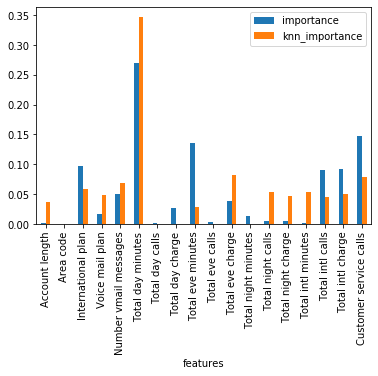

,features,importance,knn_importance
0,Account length,0.001998,0.037503
1,Area code,0.000000,0.000000
2,International plan,0.097249,0.057899
3,Voice mail plan,0.017068,0.048126
4,Number vmail messages,0.050646,0.069451
5,Total day minutes,0.270386,0.346872
6,Total day calls,0.002246,0.000000
7,Total day charge,0.026422,0.000000
8,Total eve minutes,0.135475,0.028836
9,Total eve calls,0.003614,0.000000


In [15]:
feature_importances['knn_importance'] = history_parametrs[-1]
diagramma = feature_importances.copy()
indexes = diagramma.index
diagramma.index = diagramma['features']
diagramma.drop('features', 1, inplace = True)
diagramma.plot(kind='bar');
plt.savefig("images/pic1.png", format = 'png')
plt.show()
feature_importances

Похоже? Да, похоже. Но далеко не идентично.
Интересное наблюдение. В наборе данных есть несколько фич полностью друг друга дублирующих например 'Total night minutes' и 'Total night charge'. Так обратите внимание, knn сама выпилила значительную часть таких повторяющихся фич.

Сохраним полученные результаты в файл, а то несколько неудобно возвращаться к работе....

In [22]:
parametrs_df = pd.DataFrame(history_parametrs)
parametrs_df['scores'] = history_holdout_score
parametrs_df.index.name = 'index'
parametrs_df.to_csv('parametrs_and_scores.csv')

## Выводы

Ну что же, Результат .919 сам по себе не плох для knn, ошибок в полтора раза меньше, чем в ванильной версии и на 7% меньше, чем когда feature_importance мы взяли у дерева погонять. Но самое интересное, что теперь у нас есть feature_importance по мнению самого knn. Он несколько отличается от того, что нам сказало дерево. Например дерево и knn имеют разные мнения о том, какие из признаков для нас вообще не важны.

Ну и в конце концов. Мы получили что-то условно говоря новое и необычное, обладая запасом знания трёх лекций mlcourse.ai
ods и гуглом для ответов на простые вопросы по питону. Помоему неплохо.

## А теперь слайды

Побочным продуктом работы алгоритма является путь, который он прошёл. Путь, правда, 18-мерный, что немножечко мешает его осознанию, ну и следить в рельном времени что там алгоритм делает, учится или фигнёй занят, не так удобно. По графику ошибки это, на самом деле, не всегда видно. Ошибка может долгое время не меняться сколько-нибудь заметно, а алгоритм между тем очень занят, ползёт вдоль длинной узкой долины в адаптивном пространстве. Поэтому я применю, для начала, первый простейший но достаточно информативный подход - произвольным случайным образом спроецирую 18-мерное пространство на двумерное так чтобы вклады всех параметров вне зависимости от их значимости были единичными. На самом деле 18-мерный путь это очень мало, в своей статье <A href="https://habr.com/ru/post/221049/">Подглядываем за метаниями нейронной сети</A> я подобным же образом любовался за пространством весов всех имеющихся у нейросети синапсов и ничё так, было красиво и информативненько.

In [14]:
# Прочитал данные из файла, если возвращаюсь к работе миновав собственно этап обучения
parametrs_df = pd.read_csv('parametrs_and_scores.csv', index_col = 'index')
history_holdout_score = np.array(parametrs_df['scores'])
parametrs_df.drop('scores',axis=1)
history_parametrs = np.array(parametrs_df.drop('scores',axis=1))

Ошибка на валидации перестаёт меняться c какого-то момента. Тут бы можно было вкрутить автоматический останов обучения и пользоваться полученной функцией всю оставшуюся жизнь, но мне уже немножечко некогда. :(

In [16]:
# Ошибка на валидации перестаёт меняться начиная с какого-то момента. Посмотрим начиная с какого:
last = history_holdout_score[-1]
steps = np.arange(0, history_holdout_score.shape[0])[history_holdout_score != last].max()
print(steps/18)


35.55555555555556


За раз мы меняли по одному параметру, так что один цикл оптимизации - 18 шагов. Получается у нас было 36 осмысленных шагов, или что-то около того. Теперь попробуем визуализировать траекторию по которой обучался метод.

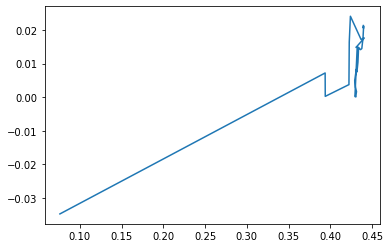

Wall time: 190 ms


In [17]:
%%time
# Задаём произвольные единичные проекции:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math
random.seed(17)
property_projection = np.array([[math.sin(a), math.cos(a)] for a in [random.uniform(-math.pi, math.pi) for i in range(history_parametrs[0].shape[0])]]).transpose()
history = np.array(history_parametrs[::18]) # Полный цикл - 18 параметров.
# Мне мозгов не зватает чтобы одно на другое помножить без циклов. :(
points = np.array([(history[i] * property_projection).sum(axis=1) for i in range(history.shape[0])])
plt.plot(points[:36,0],points[0:36,1]);
plt.savefig("images/pic2.png", format = 'png')
plt.show()

Видно, что значительную часть пути обучение прошло за первых четыре шага. Посмотрим на весь остальной путь с увеличением

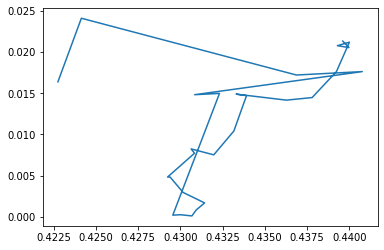

In [18]:
plt.plot(points[4:36,0],points[4:36,1]);
plt.savefig("images/pic3.png", format = 'png')

Приблизим заключительную часть пути и посмотрим что обучалка делала после того как достигла своего пункта назначения

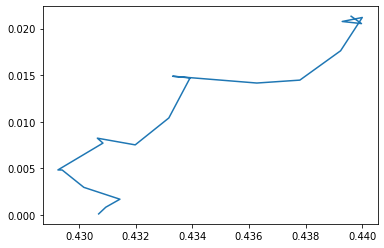

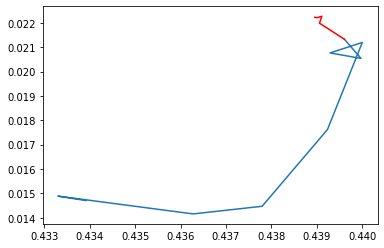

In [19]:
plt.plot(points[14:36,0],points[14:36,1]);
plt.savefig("images/pic4.png", format = 'png')
plt.show()
plt.plot(points[24:36,0],points[24:36,1]);
plt.plot(points[35:,0],points[35:,1], color = 'red');
plt.savefig("images/pic5.png", format = 'png')
plt.show()

Видно, что алгоритм сосредоточенно обучается. Пока не находит свою пункт назначения. Конкретная точка, конечно, от рандома при кроссвалидации зависит. Но вне зависимости от конкретной точки общая картина происходёщего понятна.

Я, кстати, раньше использовал такой график для демонстрации процесса обучения. Показывается не вся траектория а последние сколь-ко то шагов со скользящим сглаживанием масштаба. Пример можно посмотреть в другой моей статье <A HREF="https://habr.com/ru/post/221049/">"Подглядываем за метаниями нейронной сети"</A>. И да, конечно, каждый кто сталкивается с такой визуализацией сразу спрашивает, а почему у всех факторов одинаковый вес, важность, то у них разная. В прошлый раз в статье я попытался перевзвесить на важность синапсов и получилось менее информативно.

В этот раз вооружённый новыми знаниями попытаюсь с помощью t-Sne развернуть многомерное пространство в такую проекцию, в которой всё может быть лучше.

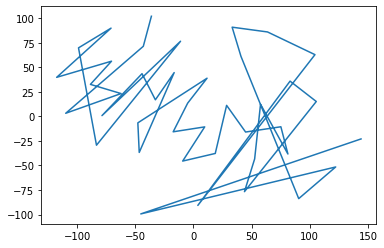

Wall time: 483 ms


In [20]:
%%time
import sklearn.manifold as manifold
tsne = manifold.TSNE(random_state=19)
tsne_representation = tsne.fit_transform(history)
plt.plot(tsne_representation[:, 0], tsne_representation[:, 1])
plt.savefig("images/pic6.png", format = 'png')
plt.show();

t-Sne похоже развернул пространство так, что начисто съел масштаб изменений по тем фичам, которые быстро перестали меняться, чем сделал картинку совершенно неинформативной. Вывод - не пытайтесь подсовывать алгоритмы в места для них не предназначенные.:\

### Дальше можно не читать
Я ещё попытался сделать инъекцию внутрь tsne чтобы визуализировать промежуточные состояния оптимизации, в надежде, что получится красота. но получилась не красота, фигня какая-то. Если интересно - посмотрите как это сделать. В интернете валяется куча примеров кода такой инъекии но простым копированием они не ра ботают, потому что подменяют содержащуюся в __sklearn.manifold.t_sne__ внутреннюю функцию __\_gradient_descent__ а она в зависимости от версии может сильно отличаться как по сигнатуре так и по обращению с внутренними переменными. Так что просто находи у себя исходники выковыриваем оттуда вашу версию функции и вставляем в неё всего одну строчку складывающую промежуточные дампы в вашу какую-то вашу переменную:<br><br>
positions.append(p.copy()) # We save the current position.
<br><br> А потом типа красиво визуализируем то что получается в результате

In [21]:
from time import time
from scipy import linalg
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    # The documentation of this function can be found in scikit-learn's code.
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        positions.append(p.copy()) # We save the current position.
        
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i

manifold.t_sne._gradient_descent = _gradient_descent

In [22]:
tsne_representation = manifold.TSNE(random_state=17).fit_transform(history)
X_iter = np.dstack(position.reshape(-1, 2) for position in positions)
position_reshape = [position.reshape(-1, 2) for position in positions]
print(position_reshape[0].shape)
print('[0] min', position_reshape[0][:,0].min(),'max', position_reshape[0][:,0].max())
print('[1] min', position_reshape[1][:,0].min(),'max', position_reshape[1][:,0].max())
print('[2] min', position_reshape[2][:,0].min(),'max', position_reshape[2][:,0].max())

(41, 2)
[0] min -0.00018188123 max 0.00027207955
[1] min -0.05136269 max 0.032607622
[2] min -4.392309 max 7.9074526


Значения пляшут в очень широких пределах, поэтому прежде чем их рисовать отмасштабирую их. На циклах всё это делается капец медленно. :(

In [23]:
%%time
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
minMaxScaler.fit_transform(position_reshape[0])
position_reshape = [minMaxScaler.fit_transform(frame) for frame in position_reshape]
position_reshape[0].min(), position_reshape[0].max()

Wall time: 172 ms


(0.0, 1.0)

Wall time: 1.52 s


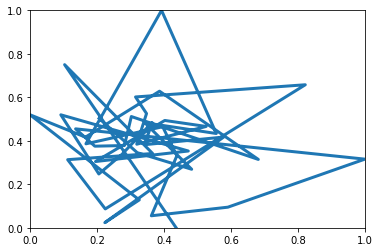

In [26]:
%%time

from matplotlib.animation import FuncAnimation, PillowWriter
#plt.style.use('seaborn-pastel')

fig = plt.figure()

ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = position_reshape[i][:,0]
    y = position_reshape[i][:,1]
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=36, interval=20, blit=True, repeat_delay = 1000)
anim.save('images/animate_tsne_learning.gif', writer=PillowWriter(fps=5))
